#Visualizing class activation heatmaps using GradientTape

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import urllib

In [3]:
# Download the animal image
source = 'http://baby-i-y.com/wp/wp-content/uploads/2015/03/pixabay/1/baby_1425195446-730x410.jpg' # Specify the image link here
dest = 'animal.jpg'
urllib.request.urlretrieve(source, dest)

('animal.jpg', <httplib.HTTPMessage instance at 0x7f0fdee48d40>)

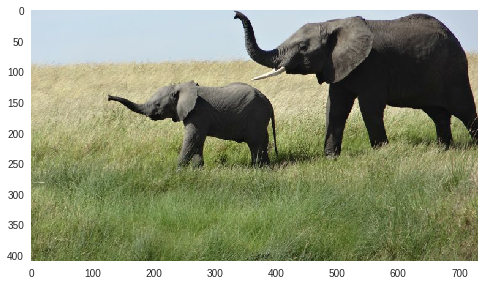

In [4]:
img = plt.imread(dest)
plt.imshow(img)
plt.grid(False)

In [0]:
# Image preprocessing
img = image.load_img(dest, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [6]:
# Load the pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet')

553476096/553467096 [==============================] - 13s 0us/step


In [7]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 1us/step
('Predicted:', [(u'n02504458', u'African_elephant', 0.76974726), (u'n01871265', u'tusker', 0.22213584), (u'n02504013', u'Indian_elephant', 0.0068778624)])


In [8]:
class_idx = np.argmax(preds[0])
class_idx

386

In [0]:
# Create a new model that will return the VGG output as well as the last convolutional layer (block5_conv3) output, given the VGG input:
new_model = Model(inputs=model.input, outputs=[model.get_layer('block5_conv3').output, model.output])

In [10]:
# Obtain the gradient of the "african elephant" class with regard to the output feature map of the last conv layer (block5_conv3)
# GradientTape is used here

with tf.GradientTape() as tape:
    last_conv_output, model_output = new_model(x)
    prob = model_output[0, class_idx]
    print('The probability of the class is {}'.format(prob))
    loss_value = tf.log(prob)

grads = tape.gradient(loss_value, last_conv_output)

The probability of the class is 0.769747257233


In [0]:
# Each entry of pooled_grads is the mean intensity of the gradient over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [0]:
# Multiply each channel in the activation (feature map) array by "how important this channel is" with regard to the class
activation = last_conv_output[0].numpy()
channel_weighting = pooled_grads.numpy()

for i in range(512):
    activation[:, :, i] *= channel_weighting[i]

In [0]:
# Calculate the mean heatmap
heatmap = np.mean(activation, axis=-1)

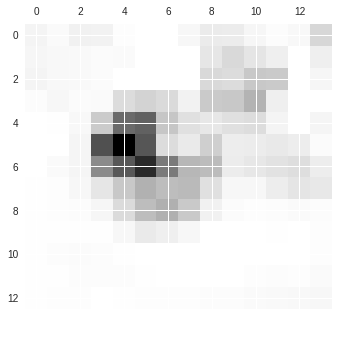

In [14]:
# Heatmap normalization
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [15]:
# Now superimposing the original image with the heatmap:
import cv2

img = cv2.imread(dest)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

# Apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

# Save the image
cv2.imwrite('visualization.jpg', superimposed_img)

True

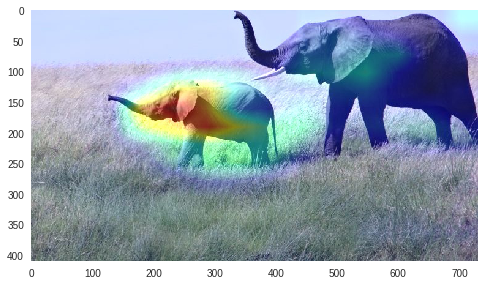

In [16]:
img_v = plt.imread('visualization.jpg')
plt.imshow(img_v)
plt.grid(False)